In [3]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.7 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [7]:
import pandas as pd
df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [10]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [11]:
747/4825

0.15481865284974095

<small>spam ratio: 0.15481865284974095</small>

## Preprocess Dataset

In [13]:
spam = df[df['Category']== 'spam']
spam

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [14]:
ham = df[df['Category']== 'ham']
ham

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...
...,...,...
5565,ham,Huh y lei...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [16]:
# downsampled
ham_downsampled = ham.sample(spam.shape[0])
ham_downsampled.shape

(747, 2)

In [23]:
df_balanced = pd.concat([spam, ham_downsampled])
df_balanced["spam"] = df_balanced["Category"].apply(lambda x: 1 if x=="spam" else 0)
df_balanced

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1
...,...,...,...
3757,ham,Yes:)here tv is always available in work place..,0
2417,ham,"Could you not read me, my Love ? I answered you",0
613,ham,I have many dependents,0
1327,ham,"Sorry, was in the bathroom, sup",0


In [20]:
df_balanced.shape

(1494, 2)

In [24]:
df_balanced.head()

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


Splitting Dataset

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'], random_state=42, shuffle=True)
X_train.head()

4873    Hi dis is yijue i would be happy to work wif ü...
2052    Hey darlin.. i can pick u up at college if u t...
532     What Today-sunday..sunday is holiday..so no wo...
745       Men like shorter ladies. Gaze up into his eyes.
240     U 447801259231 have a secret admirer who is lo...
Name: Message, dtype: object

In [30]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [31]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [32]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [34]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

## Build Model

In [36]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [38]:
len(X_train)

1120

In [39]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [40]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 611s 17s/step - loss: 0.6361 - accuracy: 0.6500 - precision: 0.6567 - recall: 0.6286
Epoch 2/10
35/35 [==============================] - 576s 16s/step - loss: 0.5207 - accuracy: 0.8098 - precision: 0.7821 - recall: 0.8589
Epoch 3/10
35/35 [==============================] - 570s 16s/step - loss: 0.4649 - accuracy: 0.8330 - precision: 0.8324 - recall: 0.8339
Epoch 4/10
35/35 [==============================] - 567s 16s/step - loss: 0.4110 - accuracy: 0.8679 - precision: 0.8652 - recall: 0.8714
Epoch 5/10
35/35 [==============================] - 569s 16s/step - loss: 0.3833 - accuracy: 0.8786 - precision: 0.8569 - recall: 0.9089
Epoch 6/10
35/35 [==============================] - 573s 16s/step - loss: 0.3518 - accuracy: 0.8911 - precision: 0.8776 - recall: 0.9089
Epoch 7/10
35/35 [==============================] - 574s 16s/step - loss: 0.3315 - accuracy: 0.8938 - precision: 0.8848 - recall: 0.9054
Epoch 8/10
35/35 [=======================

In [41]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 203s 16s/step - loss: 0.2518 - accuracy: 0.9225 - precision: 0.8835 - recall: 0.9733


[0.25181111693382263,
 0.9224599003791809,
 0.8834951519966125,
 0.9732620120048523]

In [42]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 188s 16s/step


In [43]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[163,  24],
       [  5, 182]])

Text(50.722222222222214, 0.5, 'Truth')

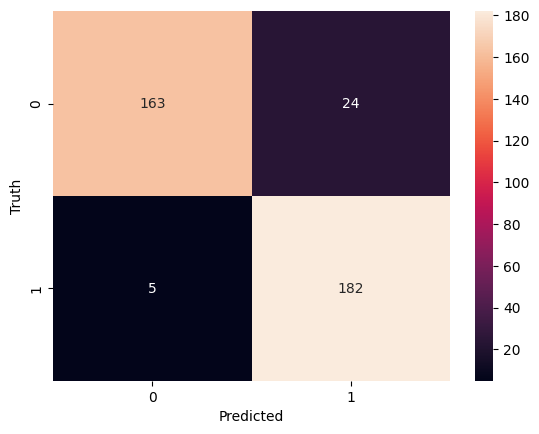

In [45]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [46]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       187
           1       0.88      0.97      0.93       187

    accuracy                           0.92       374
   macro avg       0.93      0.92      0.92       374
weighted avg       0.93      0.92      0.92       374



In [47]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 9s 9s/step


array([[0.79481417],
       [0.86957276],
       [0.84761786],
       [0.3015936 ],
       [0.15494354]], dtype=float32)